Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Copy Dataset

In [ ]:
!cp "/content/drive/MyDrive/images (1)" /content/data -r

UTILITIES

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import InputSpec
from keras.layers import Layer
from keras.layers import Input, Conv2D, Activation, BatchNormalization
from keras.layers import Add
from tensorflow.python.keras.utils import conv_utils
from keras.layers import Dropout

# Define a function to create a residual block
def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    """
    Instantiate a Keras Res-net Block using sequential API.

    :param input: Input tensor
    :param filters: Number of filters to use
    :param kernel_size: Shape of the kernel for the convolution
    :param strides: Shape of the strides for the convolution
    :param use_dropout: Boolean value to determine the use of dropout
    :return: Keras Model
    """
    # Apply reflection padding to the input
    x = ReflectionPadding2D((1, 1))(input)
    # Convolutional layer
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    # Batch normalization and activation
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optionally apply dropout
    if use_dropout:
        x = Dropout(0.5)(x)

    # Apply reflection padding again
    x = ReflectionPadding2D((1, 1))(x)
    # Another convolutional layer
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    # Batch normalization
    x = BatchNormalization()(x)

    # Add the input to the output of the second convolution
    merged = Add()([input, x])
    return merged

# Function to apply spatial reflection padding to a 4D tensor
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.

    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],
                   [0, 0],
                   list(padding[0]),
                   list(padding[1])]
    else:
        pattern = [[0, 0],
                   list(padding[0]), list(padding[1]),
                   [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

# Custom layer for reflection padding
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), data_format=None, **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)

        self.data_format = conv_utils.normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. '
                                 'Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,
                                                        '1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,
                                                       '2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, '
                             'a tuple of 2 ints '
                             '(symmetric_height_pad, symmetric_width_pad), '
                             'or a tuple of 2 tuples of 2 ints '
                             '((top_pad, bottom_pad), (left_pad, right_pad)). '
                             'Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    input_shape[1],
                    rows,
                    cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,
                                             padding=self.padding,
                                             data_format=self.data_format)

    def get_config(self):
        config = {'padding': self.padding,
                  'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Create a test model using the ReflectionPadding2D layer
input = Input(shape=(256, 256, 3))
x = ReflectionPadding2D(3)(input)
model = Model(input, x)

**Defining our LOSSES**

In [ ]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
import numpy as np
import cv2

# Define the image shape (must be a multiple of patch_shape for some operations)
image_shape = (256, 256, 3)

# Load pre-trained VGG16 model without top (fully connected layers)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)

# Custom loss functions

def l1_loss(y_true, y_pred):
    """Compute the L1 loss."""
    return K.mean(K.abs(y_pred - y_true))

def perceptual_loss_100(y_true, y_pred):
    """Compute the perceptual loss scaled by a factor of 100."""
    return 100 * perceptual_loss(y_true, y_pred)

def perceptual_loss(y_true, y_pred):
    """Compute the perceptual loss based on features extracted by VGG16."""
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

def wasserstein_loss(y_true, y_pred):
    """Compute the Wasserstein loss."""
    return K.mean(y_true * y_pred)

# Gradient penalty loss for Wasserstein GANs
def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
    """Compute the gradient penalty loss."""
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)

58889256/58889256 [==============================] - 0s 0us/step


Building the MODEL

In [ ]:
from keras.layers import Input, Activation, Add, UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Lambda
from keras.layers import BatchNormalization
from keras.models import Model

# Define the channel rate for the architecture
channel_rate = 64
# Define the image shape and patch shape
image_shape = (256, 256, 3)
patch_shape = (channel_rate, channel_rate, 3)

ngf = 64  # Number of filters in the generator
ndf = 64  # Number of filters in the discriminator
input_nc = 3  # Number of input channels
output_nc = 3  # Number of output channels
input_shape_generator = (256, 256, input_nc)  # Shape of input for the generator
input_shape_discriminator = (256, 256, output_nc)  # Shape of input for the discriminator
n_blocks_gen = 9  # Number of residual blocks in the generator


def generator_model():
    """Build generator architecture."""
    # Define the input layer
    inputs = Input(shape=image_shape)

    # Initial convolutional layer with reflection padding
    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Downsampling layers
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Residual blocks
    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    # Upsampling layers
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Final convolutional layer with reflection padding
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    # Add the input to the output and normalize
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model


def discriminator_model():
    """Build discriminator architecture."""
    # Define the number of layers and whether to use sigmoid activation
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    # Initial convolutional layer with LeakyReLU activation
    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    # Intermediate convolutional layers with batch normalization and LeakyReLU activation
    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    # Final convolutional layer
    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Output layer with sigmoid activation if specified
    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    # Flatten and apply fully connected layers
    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model


def generator_containing_discriminator(generator, discriminator):
    """Build generator containing discriminator model."""
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    """Build generator containing discriminator model with multiple outputs."""
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model


if __name__ == '__main__':
    # Create instances of the generator, discriminator, and combined model
    g = generator_model()
    g.summary()
    d = discriminator_model()
    d.summary()
    m = generator_containing_discriminator(generator_model(), discriminator_model())
    m.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 reflection_padding2d_1 (Re  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 flectionPadding2D)                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['reflection_padding2d_1[0][0]
                                                                    ']                            
                                                                                          

MORE IMAGE UTILITIES

In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Global variables
RESHAPE = (256,256)

# Function to check if a filename corresponds to an image file
def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

# Function to list all image files in a directory
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

# Function to load an image from a file path
def load_image(path):
    if os.path.isdir(path):
        return None
    img = np.array(Image.open(path))
    return img

# Function to preprocess an input image
def preprocess_image(cv_img):
    cv_img = cv2.resize(cv_img, RESHAPE)
    img = np.array(cv_img)
    img = (img - 127.5) / 127.5  # Normalize pixel values to the range [-1, 1]
    return img

# Function to deprocess an image
def deprocess_image(img):
    img = img * 127.5 + 127.5  # Scale pixel values back to the range [0, 255]
    return img.astype('uint8')

# Function to save an image to a file path
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5  # Scale pixel values back to the range [0, 255]
    im = Image.fromarray(img)
    im.save(path)

# Function to load image data from a directory
def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    A_paths, B_paths = os.path.join(path, 'A'), os.path.join(path, 'B')
    all_A_paths, all_B_paths = list_image_files(A_paths), list_image_files(B_paths)
    images_A, images_B = [], []
    images_A_paths, images_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        img_A, img_B = load_image(path_A), load_image(path_B)
        images_A.append(preprocess_image(img_A))
        images_B.append(preprocess_image(img_B))
        images_A_paths.append(path_A)
        images_B_paths.append(path_B)
        if len(images_A) > n_images - 1: break

    return {
        'A': np.array(images_A),
        'A_paths': np.array(images_A_paths),
        'B': np.array(images_B),
        'B_paths': np.array(images_B_paths)
    }

# Function to write logs during training for Keras callbacks
def write_log(callback, names, logs, batch_no):
    """
    Util to write callback for Keras training
    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()


In [ ]:
import os
from shutil import copyfile

import tqdm


def reorganize_data_files(dir_in, dir_out):
    # Create output directory if it doesn't exist
    if not os.path.exists(dir_out):
        os.makedirs(dir_out)

    # Define input and output directories for images A and B
    output_directory_A = os.path.join(dir_out, 'A')
    output_directory_B = os.path.join(dir_out, 'B')
    input_directory_A = os.path.join(dir_in, 'A')
    input_directory_B = os.path.join(dir_in, 'B')
    input_directory_C = os.path.join(dir_in, 'C')

    # Create output directories if they don't exist
    if not os.path.exists(output_directory_A):
        os.makedirs(output_directory_A)
    if not os.path.exists(output_directory_B):
        os.makedirs(output_directory_B)

    n = 185  # Initial index for new filenames

    # Copy images from input_directory_A to output_directory_A
    for image_blurred in os.listdir(input_directory_A):
        current_image_blurred_path = os.path.join(input_directory_A, image_blurred)
        output_image_blurred_path = os.path.join(output_directory_A, image_blurred)
        copyfile(current_image_blurred_path, output_image_blurred_path)

    # Copy images from input_directory_C to output_directory_A with new filenames
    for image_blurred in os.listdir(input_directory_C):
        current_image_blurred_path = os.path.join(input_directory_C, image_blurred)
        output_image_blurred_path = os.path.join(output_directory_A, f"{n}.jpg")
        n += 1
        copyfile(current_image_blurred_path, output_image_blurred_path)

    # Copy images from input_directory_B to output_directory_B
    for image_sharp in os.listdir(input_directory_B):
        current_image_sharp_path = os.path.join(input_directory_B, image_sharp)
        output_image_sharp_path = os.path.join(output_directory_B, image_sharp)
        copyfile(current_image_sharp_path, output_image_sharp_path)

    # Copy images from input_directory_B to output_directory_B with new filenames
    for image_sharp in os.listdir(input_directory_B):
        current_image_sharp_path = os.path.join(input_directory_B, image_sharp)
        output_image_sharp_path = os.path.join(output_directory_B, f"{n}.jpg")
        n += 1
        copyfile(current_image_sharp_path, output_image_sharp_path)

# Example usage
reorganize_data_files('/content/data/images (1)', 'images_data')

TRAIN

In [ ]:
import os
import datetime
import click
import numpy as np
import tqdm

from keras.callbacks import TensorBoard
from keras.optimizers import Adam

BASE_DIR = 'weights/'

def save_all_weights(d, g, epoch_number, current_loss):
    now = datetime.datetime.now()
    save_dir = os.path.join(BASE_DIR, '{}{}'.format(now.month, now.day))
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Save generator and discriminator weights
    g.save_weights(os.path.join(save_dir, 'generator_{}_{}.h5'.format(epoch_number, current_loss)), True)
    d.save_weights(os.path.join(save_dir, 'discriminator_{}.h5'.format(epoch_number)), True)

import numpy as np
import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

def train_multiple_outputs(n_images, batch_size, log_dir, epoch_num, critic_updates=5):
    # Load images for training
    data = load_images('./images_data', n_images)
    y_train, x_train = data['B'], data['A']

    # Initialize generator, discriminator, and combined model
    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    # Optimizer initialization
    d_opt = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Compile discriminator and combined model
    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]  # Loss functions for the combined model
    loss_weights = [100, 1]  # Weighting of different losses
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True

    # Define true and false labels for discriminator
    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

    # Initialize TensorBoard callback for logging
    log_path = './logs'
    tensorboard_callback = TensorBoard(log_path)

    # Training loop over epochs
    for epoch in tqdm.tqdm(range(epoch_num)):
        # Shuffle training data indices
        permutated_indexes = np.random.permutation(x_train.shape[0])

        d_losses = []
        d_on_g_losses = []
        # Iterate over mini-batches
        for index in range(int(x_train.shape[0] / batch_size)):
            batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
            image_blur_batch = x_train[batch_indexes]
            image_full_batch = y_train[batch_indexes]

            # Generate images with the generator
            generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

            # Train discriminator
            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            # Freeze discriminator and train combined model
            d.trainable = False
            d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
            d_on_g_losses.append(d_on_g_loss)
            d.trainable = True

        # Logging losses to file
        with open('log.txt', 'a+') as f:
            f.write('{} - {} - {}\n'.format(epoch, np.mean(d_losses), np.mean(d_on_g_losses)))

        # Save weights at each epoch
        save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))

def train_command(n_images, batch_size, log_dir, epoch_num, critic_updates):
    return train_multiple_outputs(n_images, batch_size, log_dir, epoch_num, critic_updates)

train_command(300,16,True,10,5)

In [ ]:
#!cp "/content/drive/MyDrive/Weights/" /content/weights -r

TESTING MULTIPLE IMAGES

In [ ]:
import numpy as np
from PIL import Image
import click

def test(batch_size):
    # Load test images
    data = load_images('./images_data', batch_size)
    y_test, x_test = data['B'], data['A']

    # Load generator model
    g = generator_model()
    # Load pre-trained weights
    g.load_weights('/content/weights/weights/417/generator_9_2183.h5')

    # Generate enhanced images
    generated_images = g.predict(x=x_test, batch_size=batch_size)

    # Convert generated images to uint8 format
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    generated = deprocess_image(y_test)

    # Save and display results for each image
    for i in range(generated_images.shape[0]):
        y = generated[i, :, :, :]
        x = x_test[i, :, :, :]
        output = np.concatenate((y, x), axis=1)
        im = Image.fromarray(output.astype(np.uint8))
        im.save('results{}.png'.format(i))
        # Display input and output images side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(x, cmap='gray')
        plt.title('Input')
        plt.subplot(1, 2, 2)
        plt.imshow(y, cmap='gray')
        plt.title('Output')
        plt.show()

# Define a wrapper function for click command
def test_command(batch_size):
    return test(batch_size)

# Example usage of the test function
test_command(16)

TESTING SINGLE IMAGE

1/1 [==============================] - 3s 3s/step


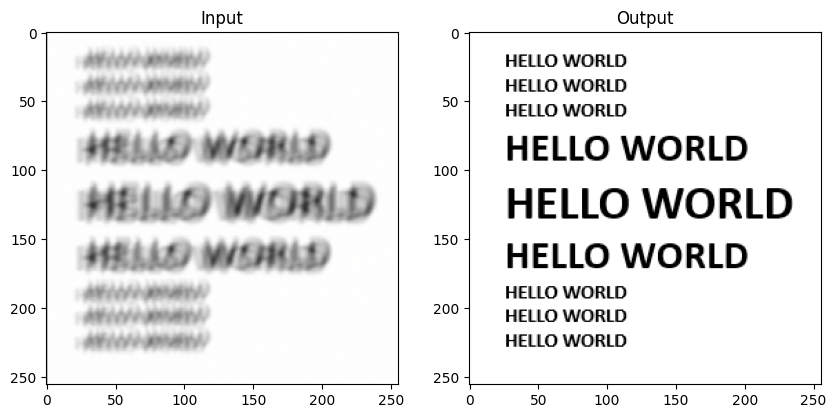

In [ ]:
import numpy as np
from PIL import Image
import os

def deblur(weight_path, input_dir, output_dir):
    # Load the generator model and its weights
    g = generator_model()
    g.load_weights(weight_path)

    # Iterate over images in the input directory
    for image_name in os.listdir(input_dir):
        try:
            # Load and preprocess the input image
            k = load_image(os.path.join(input_dir, image_name))
            image = np.array([preprocess_image(k)])
            image = image[:, :, :, :3]  # Ensure input has correct shape
            x_test = image

            # Generate the deblurred image
            generated_images = g.predict(x=x_test)
            generated = np.array([deprocess_image(img) for img in generated_images])
            x_test = deprocess_image(x_test)

            # Save and display the input and output images
            for i in range(generated_images.shape[0]):
                x = x_test[i, :, :, :]
                img = generated[i, :, :, :]
                output = np.concatenate((x, img), axis=1)
                im = Image.fromarray(output.astype(np.uint8))
                im.save(os.path.join(output_dir, image_name))  # Save the output image
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(x, cmap='gray')
                plt.title('Input')
                plt.subplot(1, 2, 2)
                plt.imshow(img, cmap='gray')
                plt.title('Output')
                plt.show()  # Display the input and output images
        except:
            pass  # Skip if there's any error

# Define a wrapper function for command-line use
def deblur_command(weight_path, input_dir, output_dir):
    return deblur(weight_path, input_dir, output_dir)

# Example usage of the deblur function
deblur_command("/content/weights/weights/417/generator_9_2183.h5", "/content/input/", "/content/output/")

CALCULATING MEAN LOSS

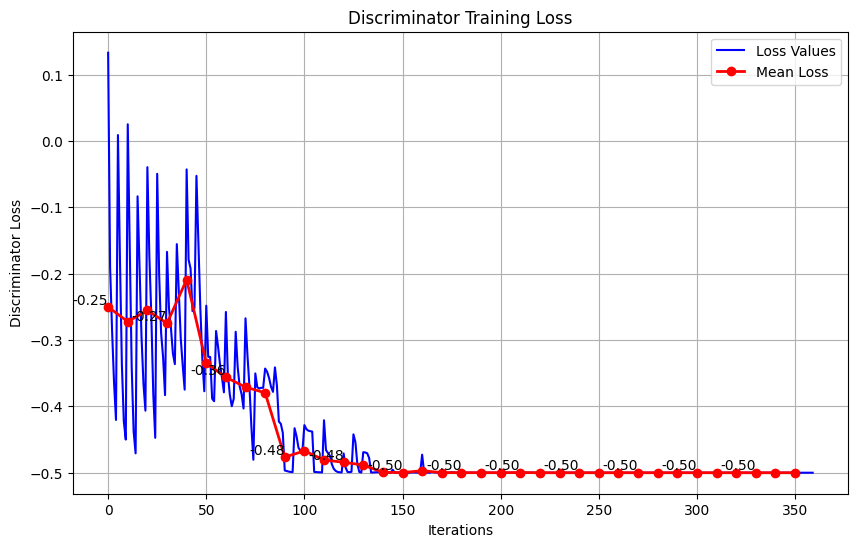

In [ ]:
x=[0.13295990228652954, -0.19045137614011765, -0.2847828958183527, -0.36323632672429085, -0.42047919891774654, 0.0088997483253479, -0.17390942573547363, -0.33687903732061386, -0.4230249337852001, -0.45004355534911156, 0.025122255086898804, -0.15960752964019775, -0.3398122042417526, -0.4378151372075081, -0.4707516711205244, -0.08345037698745728, -0.1912037581205368, -0.29427891969680786, -0.36545491963624954, -0.4064338579773903, -0.03952467441558838, -0.17265772074460983, -0.2628582641482353, -0.3808385245501995, -0.4473850540816784, -0.04950892925262451, -0.20087802410125732, -0.2895565330982208, -0.3259362056851387, -0.3830520361661911, -0.1671852469444275, -0.2520267069339752, -0.2815994322299957, -0.32014232128858566, -0.33632462471723557, -0.15550485998392105, -0.22630969434976578, -0.29745129495859146, -0.3382686525583267, -0.37476567178964615, -0.042878761887550354, -0.17888350784778595, -0.19219768047332764, -0.2564508765935898, -0.2516881823539734, -0.05262112617492676, -0.1557467132806778, -0.2539256289601326, -0.3282754346728325, -0.3772107884287834, -0.24829384684562683, -0.3253294676542282, -0.3254803344607353, -0.38837649673223495, -0.39225370809435844, -0.2864026725292206, -0.30966292321681976, -0.33656879141926765, -0.3562832809984684, -0.3788269590586424, -0.25770822912454605, -0.35140572488307953, -0.3821180462837219, -0.39979138225317, -0.388621523976326, -0.2875519096851349, -0.3401753753423691, -0.36949577927589417, -0.3817015290260315, -0.40325675159692764, -0.2672896832227707, -0.3233736380934715, -0.3697497844696045, -0.43061601370573044, -0.48042408376932144, -0.35036198794841766, -0.37113597989082336, -0.37314698100090027, -0.371955007314682, -0.37211595475673676, -0.34300998598337173, -0.34786881506443024, -0.3572339788079262, -0.37035272270441055, -0.37815991789102554, -0.3412233963608742, -0.3684876412153244, -0.4229530394077301, -0.4263039529323578, -0.43984515592455864,-0.496652317000553, -0.4973913134308532, -0.4983275078702718, -0.4988146754913032, -0.49907213350525126, -0.43294044584035873, -0.4450402781367302, -0.4623358026146889, -0.467186126857996, -0.467257559299469, -0.4282546937465668, -0.43422046303749084, -0.4366421103477478, -0.43738923594355583, -0.4380365163087845, -0.49879501143004745, -0.4990318638738245, -0.4992563265841454, -0.4994233095785603, -0.49954302969854325, -0.42097702622413635, -0.46573032438755035, -0.470291955396533, -0.47417113184928894, -0.48728911578655243, -0.49427413661032915, -0.49734412459656596, -0.4989471076405607, -0.49940778795280494, -0.4995369471726008, -0.47098811576142907, -0.4922297189186793, -0.49888376143644564, -0.4991053691483103, -0.49864351633004844, -0.44216907024383545, -0.4540453888475895, -0.48744189366698265, -0.49887360888533294, -0.4997789506742265, -0.4690661858767271, -0.46942993998527527, -0.4705671090632677, -0.4778977017849684, -0.49966907274210826, -0.49964597047073767, -0.4994173944287468, -0.49918520863866434, -0.4991795119130984, -0.4993936613900587, -0.49985144086531363, -0.4998802850896027, -0.4999030825056252, -0.49992029892018763, -0.49993303289375035, -0.4954448968055658, -0.49951220222283155, -0.49983177510875976, -0.4999047283708933, -0.4999342276387324, -0.4998404824291356, -0.49984483201114926, -0.49985287836170755, -0.499863569624722, -0.4998755287961103, -0.4995416084129829, -0.4996842016116716, -0.4998010397539474, -0.4998640378616983, -0.4998960752200219, -0.4727919715041935, -0.49928413307497976, -0.49981933019444114, -0.49989012769947294, -0.49988275391660864, -0.49915995687479153, -0.49941580271115527, -0.4997170191782061, -0.49982905195793137, -0.4998612564522773, -0.4999598364265694, -0.4999591377818433, -0.4999591277446598, -0.4999596779452986, -0.49996071831992595, -0.49920779012609273, -0.49954983944189735, -0.4997849553474225, -0.4998914291500114, -0.49993808471481316,-0.49986874566820916, -0.4998893923475407, -0.4999070979320095, -0.4999217068325379, -0.4999334055246436, -0.4999394344490611, -0.49994153620264115, -0.4999447250679623, -0.4999485536636712, -0.49995262663469475, -0.4996646711952053, -0.49974594815284945, -0.4998299657017924, -0.4998881895735394, -0.4999234186470858, -0.4999758544618089, -0.49997653930950037, -0.4999771859111206, -0.49997773025279457, -0.4999782298109494, -0.49986825560336, -0.49987602983310353, -0.49988593026500894, -0.4998966272396501, -0.49990713390434394, -0.49999796650627104, -0.4999980155890853, -0.4999980537261308, -0.4999980836279292, -0.4999981073892741, -0.4977980034891516, -0.49930970650166273, -0.49980356053856667, -0.4999296726164175, -0.4999673227866879, -0.4999975379337229, -0.4999975857477921, -0.4999976341002821, -0.4999976624942519, -0.4999976469621288, -0.49998182550370984, -0.4999823264824954, -0.49998287206290115, -0.4999834419468243, -0.4999840215896256, -0.4999843099021746, -0.4999846898017495, -0.4999850221820452, -0.49998536750626954, -0.4999856958465898, -0.49999627738020536, -0.4999963129594107, -0.49999634241748936, -0.4999963670222769, -0.499996387754436, -0.4999955934949867, -0.49999560363016826, -0.49999561554614047, -0.4999956288888825, -0.4999956433389343, -0.4998617758005821, -0.4998851823302175, -0.49991333044681596, -0.49993581753869876, -0.4999513314110118, -0.4999838464182176, -0.4999852827650102, -0.4999864188844185, -0.49998731458572365, -0.4999879997626522, -0.4999947898971868, -0.499994912082002, -0.4999949743794332, -0.49999506624908463, -0.49999515793251703, -0.49998728917307744, -0.49998732363746967, -0.49998737737223564, -0.49998744646472915, -0.49998752748615516, -0.4999849547175472, -0.4999850613057788, -0.4999851762313483, -0.4999852976143302, -0.4999854239204069, -0.4999974214788381, -0.49999742573470485, -0.4999974297564904, -0.4999974335889874, -0.4999974372643692,-0.4999932807402274, -0.49999331516642087, -0.4999933204280751, -0.49999335599341066, -0.4999933621584205, -0.499998195370722, -0.4999981973530794, -0.4999981993991014, -0.4999982014928719, -0.49999820362063474, -0.4999887454897589, -0.49998889581434014, -0.499989106080875, -0.49998934641644155, -0.4999896465709526, -0.49997866767535015, -0.4999791271993672, -0.4999796526094542, -0.4999801830085744, -0.4999807471413078, -0.4999982780989285, -0.49999827923170415, -0.49999831023563956, -0.49999834129727105, -0.4999983127998462, -0.49999833994775145, -0.4999983413397331, -0.49999834281618405, -0.4999983443593692, -0.4999983459622399, -0.4999766494256619, -0.4999768818852317, -0.49997730838367715, -0.4999778240071464, -0.49997844889730914, -0.4999814727470948, -0.4999816379308868, -0.4999818314990989, -0.4999821132678335, -0.49998239398610167, -0.49999218746143015, -0.49999223680288196, -0.499992296405253, -0.4999923934929029, -0.4999924664562059, -0.49998857099637917, -0.4999887559297349, -0.4999890002120537, -0.49998927407978044, -0.4999896371652994, -0.49998935136227374, -0.4999894232232691, -0.4999895357977948, -0.49998965706981835, -0.4999897554093877, -0.49999824858008424, -0.4999982203947866, -0.49999825167253675, -0.4999982530353009, -0.4999982543073429, -0.49999755749377073, -0.49999755829003334, -0.4999975888101176, -0.49999761926818564, -0.4999976198737386, -0.49999140712679946, -0.49999141968828553, -0.4999914396371423, -0.49999149532413867, -0.4999915557150416, -0.49999406972574434, -0.4999940763095765, -0.49999408321264127, -0.4999941201749607, -0.49999415733850583, -0.4999952000317762, -0.4999952025931407, -0.4999952646976453, -0.49999526714452713, -0.4999952993500756, -0.49998733922620886, -0.4999874614518376, -0.4999876144956943, -0.49998779813154215, -0.4999880121822571, -0.49999501456750295, -0.49999502933133044, -0.4999950463238747, -0.49999506509220737, -0.49999508525343117,-0.49999668825171284, -0.499996695455593, -0.49999670262832296, -0.4999967097824083, -0.49999674670993954, -0.49999604530580655, -0.49999605476023135, -0.499996065549567, -0.499996077393007, -0.49999609008091284, -0.4999938624241622, -0.4999938809446576, -0.4999939050467219, -0.49999393356256405, -0.49999396553175757, -0.499998210379033, -0.49999821260951194, -0.4999982145664035, -0.4999982162963761, -0.49999824764745426, -0.4999922560051573, -0.4999923162308164, -0.49999237633431903, -0.4999924661415207, -0.49999255586959634, -0.49998078435828575, -0.49998111941795287, -0.49998157740947136, -0.49998215752748365, -0.4999827995407031, -0.4999865822283027, -0.49998674584639957, -0.49998693110592285, -0.4999871543750487, -0.4999874046552577, -0.49999647411436854, -0.49999650683582786, -0.49999650937445494, -0.4999965712070207, -0.49999660298817616, -0.49999222596005666, -0.49999228698152365, -0.49999237735681845, -0.49999246737388603, -0.4999925869031472, -0.4999932380113705, -0.49999329837817186, -0.49999335888958285, -0.4999933599160613, -0.4999934206479111, -0.49999003059087954, -0.4999901222272456, -0.4999902158031091, -0.4999903705640918, -0.4999905265981397, -0.4999941253608995, -0.4999941337564451, -0.49999418173365484, -0.49999420766107505, -0.4999942396680126, -0.49999116662911547, -0.49999121779683264, -0.49999127623414097, -0.4999913105439191, -0.4999913790725259, -0.49999645521404545, -0.4999964570973816, -0.4999964886156931, -0.4999965199976941, -0.49999652146755125, -0.49999851217580726, -0.4999985144125958, -0.4999985168009289, -0.4999985193110206, -0.49999852191808714, -0.49999479831058125, -0.4999948087915982, -0.4999948240320009, -0.49999484307772946, -0.49999486510978386, -0.49999463442509295, -0.4999946539519442, -0.49999468356872967, -0.499994721060375, -0.4999947645164866, -0.499991515525835, -0.49999155392833927, -0.4999915745429462, -0.49999166412089835, -0.49999173110336415,-0.4999979016870384, -0.49999790346510053, -0.499997905129419, -0.49999790670312905, -0.49999790819941836, -0.49999409874635603, -0.4999941127944112, -0.4999941299724924, -0.4999941496153042, -0.4999941711980682, -0.49999462479718204, -0.49999467649831786, -0.49999470657257916, -0.4999947132205307, -0.4999947545438772, -0.4999898757214396, -0.49998988630159147, -0.4999899569847912, -0.49999002807999204, -0.4999901292958384, -0.49999563716119155, -0.4999956429073791, -0.4999956504216243, -0.49999565934808743, -0.499995669404143, -0.4999976479311954, -0.4999976505689574, -0.49999765338520774, -0.49999768614384266, -0.4999976892115683, -0.49999189019399637, -0.49999191748202065, -0.4999919622378002, -0.49999202071376203, -0.4999920896752883, -0.49999753684426196, -0.49999754219868464, -0.49999757660634714, -0.49999758061414923, -0.4999975841391233, -0.4999990640682199, -0.49999906444230646, -0.499999064796242, -0.49999906513434667, -0.49999906545897943, -0.4999859282174839, -0.4999860462826291, -0.49998624532327085, -0.49998652051453973, -0.4999867784140406, -0.4999947520277601, -0.4999947689691453, -0.4999948212130221, -0.4999948479330669, -0.49999487790773856, -0.4999909371863396, -0.4999909968155407, -0.49999108356678335, -0.4999911908307695, -0.49999131314416445, -0.4999984600683547, -0.49999846596438147, -0.49999847134427, -0.4999984763019256, -0.4999984809170428, -0.49999537875919486, -0.4999953955566525, -0.49999541805664194, -0.49999544505317317, -0.4999954755212457, -0.4999971731554069, -0.49999717898731433, -0.49999718667868365, -0.49999719585571256, -0.4999972360076299, -0.4999980964568067, -0.49999809718946153, -0.4999980978556664, -0.4999980984676995, -0.4999981288370918, -0.499998217374241, -0.4999982202114097, -0.49999822374888936, -0.49999822784809567, -0.4999982323920449, -0.4999989795800275, -0.49999898044325164, -0.4999989813041452, -0.49999898216526617, -0.49999898302706924,-0.49999832523212717, -0.4999983261247962, -0.49999832720163795, -0.49999832842559044, -0.4999983297673225, -0.49998290177791205, -0.49998306432462414, -0.4999833427282283, -0.49998370504545164, -0.4999841240205569, -0.4999984442013101, -0.4999984536480042, -0.49999846157834327, -0.4999984682935974, -0.4999984740329637, -0.49999803039031576, -0.4999980335617238, -0.49999803643038376, -0.4999980390540486, -0.4999980414786478, -0.49999918023348755, -0.499999180847567, -0.499999181413159, -0.4999991819386196, -0.49999918243020147, -0.4999989156137872, -0.49999888675677084, -0.49999888780428137, -0.49999888893319167, -0.49999891992820267, -0.49999938034108027, -0.49999938078588, -0.49999938132009447, -0.4999993819267843, -0.4999993825906017, -0.4999951962936393, -0.4999952160255816, -0.4999952478283376, -0.49999528895978074, -0.49999533713344135, -0.4999966672364735, -0.4999966794048305, -0.4999967217770518, -0.49999676421089134, -0.49999683622968405, -0.4999983934555985, -0.49999839590554984, -0.4999983984364462, -0.4999984010355547, -0.4999984036879823, -0.49999731380012236, -0.4999973183585098, -0.499997323943262, -0.4999973303513343, -0.49999733741788077, -0.4999978405337515, -0.49999784365672895, -0.4999978476614615, -0.4999978523651407, -0.4999978576247486, -0.49999808971324455, -0.49999809251596616, -0.4999980958447168, -0.4999980995954729, -0.4999981036819463, -0.4999970419407873, -0.49999704866036154, -0.4999970569501784, -0.4999970665003275, -0.4999970770413711, -0.4999940953730402, -0.49999410784676, -0.49999412578017655, -0.4999941480364214, -0.4999941736641631, -0.4999975133552539, -0.4999975151301328, -0.4999975465587454, -0.4999975480653802, -0.49999757927565724, -0.49999946319505284, -0.4999994633589466, -0.49999946349815616, -0.4999994636175842, -0.4999994637206555, -0.4999984650572742, -0.499998466262241, -0.4999984679730005, -0.499998470089281, -0.4999984725336617,-0.4999993411693424, -0.49999934143841074, -0.49999934169332505, -0.4999993419382065, -0.49999934217274244, -0.499995680297161, -0.49999568780867776, -0.49999570014188066, -0.49999571628177364, -0.4999957652075864, -0.49999921038931916, -0.49999921111145795, -0.4999992117653278, -0.49999921236423006, -0.4999992129173165, -0.49999770509498376, -0.4999977059435423, -0.4999977368455575, -0.4999977381471581, -0.4999977396125814, -0.49999803905120643, -0.4999980407200155, -0.4999980430694677, -0.4999980459692779, -0.4999980493108751, -0.4999955426519591, -0.4999955635121296, -0.4999955965768095, -0.4999956391343403, -0.4999956889137138, -0.4999975758337314, -0.49999758426929475, -0.499997564957539, -0.49999760685432193, -0.49999759040520075, -0.4999970791814121, -0.4999970856060827, -0.4999970937517446, -0.49999710327074354, -0.499997113873178, -0.4999986394360576, -0.4999986426405485, -0.4999986465222719, -0.4999986509366181, -0.49999865577308356, -0.49999754479858893, -0.4999975483876824, -0.4999975527641709, -0.49999755777162136, -0.49999756328134026, -0.4999975837608872, -0.4999975892415023, -0.499997596478579, -0.4999976051255999, -0.4999976148797032, -0.4999991394040535, -0.49999914045133664, -0.49999914147383606, -0.4999991424757013, -0.49999914346113883, -0.4999979409917614, -0.4999979447770784, -0.49999794983955326, -0.4999979559274834, -0.4999979628262281, -0.49999953101684014, -0.4999995314667558, -0.49999953187892743, -0.49999953226136995, -0.49999953261888663, -0.4999987087878708, -0.49999871032571264, -0.4999986825121141, -0.49999868485940624, -0.49999868749807774, -0.4999985486958849, -0.4999985798124271, -0.4999985816100434, -0.4999985539938052, -0.49999858629701066, -0.49999748805998934, -0.49999752213852844, -0.49999752788744445, -0.49999750501660856, -0.4999975426878791, -0.4999979716242251, -0.4999979766064371, -0.49999798282397023, -0.4999979900337621, -0.499997998013896,-0.49999924309071275, -0.4999992443490555, -0.4999992457105691, -0.4999992471543919, -0.49999924866693846, -0.499999422527992, -0.4999994229061713, -0.4999994232766767, -0.4999994236419525, -0.4999994240022261, -0.49999783678663334, -0.49999783942098475, -0.4999978432466605, -0.49999784803503644, -0.4999978535873879, -0.4999986297526675, -0.4999986316597642, -0.49999863383698084, -0.49999860642458316, -0.4999986387872468, -0.49999820075117896, -0.49999820351945345, -0.4999982075490834, -0.49999821258347765, -0.4999982184227747, -0.4999966055779623, -0.49999660903858967, -0.49999661312494936, -0.49999664751203454, -0.4999966524919728, -0.49999874571778946, -0.49999874753791573, -0.49999874965487834, -0.49999875200762744, -0.4999987545484146, -0.4999977345487423, -0.4999977391362336, -0.49999774506341055, -0.49999775205969854, -0.49999775990158923, -0.49999837820848825, -0.4999983825800882, -0.4999983877930845, -0.4999983936742183, -0.4999984000820632, -0.49999675481012673, -0.49999676109950997, -0.499996770130565, -0.49999678135691283, -0.4999967943149386, -0.4999966497625792, -0.4999966575194321, -0.49999666777011953, -0.4999966799896356, -0.499996693764615, -0.49999894952901514, -0.49999895154098795, -0.4999989535339182, -0.49999895550979545, -0.4999989574706092, -0.4999991324334019, -0.49999913343265234, -0.4999991345278545, -0.4999991356999658, -0.4999991369344343, -0.4999990848344851, -0.49999908546209326, -0.4999990861514334, -0.49999908689130734, -0.49999908767210854, -0.49999532462652496, -0.4999953442270453, -0.49999537697658525, -0.49999541997931374, -0.4999954707932375, -0.49999880458710777, -0.4999988079874811, -0.49999881169821947, -0.49999881564906445, -0.4999988197911307, -0.4999987439882716, -0.4999987455878454, -0.4999987473773899, -0.4999987493220033, -0.4999987513874089, -0.4999991731069713, -0.4999991735616618, -0.49999917399912874, -0.4999991744228396, -0.49999917483336276,-0.4999989885454852, -0.4999989893002521, -0.49999899021844385, -0.49999899126618175, -0.49999899242038737, -0.4999993926050479, -0.4999993928902313, -0.49999939323748777, -0.4999993936339706, -0.4999993940696754, -0.49999815190130903, -0.4999981538805969, -0.499998156706738, -0.49999816020772414, -0.4999981642536113, -0.4999992772185635, -0.4999992776182296, -0.4999992779987963, -0.4999992783652658, -0.4999992787192298, -0.49999713963120485, -0.4999971476779592, -0.4999971607462612, -0.49999717776131547, -0.49999719780794294, -0.4999976334306666, -0.49999763987125334, -0.4999976468304794, -0.49999765419352116, -0.4999976618828441, -0.4999990080423231, -0.4999990098949638, -0.499999011862883, -0.4999990139262991, -0.49999901606440744, -0.49999598556496494, -0.4999960037553137, -0.49999603284140903, -0.4999960703701163, -0.49999611429393553, -0.49999899054637353, -0.4999989916720722, -0.4999989926393198, -0.49999899347974974, -0.4999990240173986, -0.49999770144836475, -0.49999770633871776, -0.4999977129866693, -0.49999772103183204, -0.4999977301858962, -0.49999959107633174, -0.49999959145576156, -0.49999959178529707, -0.49999959207488587, -0.49999959233186075, -0.4999990294405734, -0.4999990303449522, -0.4999990314138927, -0.49999903261686995, -0.4999990339259739, -0.49999866161533646, -0.4999986631931961, -0.4999986653931501, -0.4999986680905977, -0.4999986711852671, -0.4999993602071129, -0.4999993606143107, -0.4999993610241802, -0.4999993614363234, -0.4999993618508256, -0.49999900846682976, -0.49999900918504636, -0.4999990100365608, -0.4999990109956798, -0.49999901204205344, -0.4999977389313699, -0.49999774135540065, -0.4999977446984758, -0.4999977487753995, -0.49999775344315367, -0.4999991703276123, -0.4999991713381178, -0.49999917251790293, -0.49999917383263437, -0.4999991752575852, -0.4999987144906868, -0.4999987152461358, -0.499998716099185, -0.499998717032895, -0.4999987180308949]

x=x[:360]
mean_losses=[]
for i in range(0, len(x), 10):
    mean_losses.append(np.mean(x[i:i+10]))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot( x, color='blue', label='Loss Values')
import numpy as np
# Plot mean loss for every 100 iterations
plt.plot(np.arange(0, len(x), 10), mean_losses, color='red', marker='o', linestyle='-', linewidth=2, label='Mean Loss')
plt.xlabel('Iterations')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Training Loss')
plt.legend()
plt.grid(True)
iterations = list(range(0, len(x), 10))  # Assuming 900 iterations

for i in range(0,len(iterations),3):
    plt.text(iterations[i], mean_losses[i], f'{mean_losses[i]:.2f}', ha='right', va='bottom')
